### Title: NN Model Evaluation

Author: Rhys Kilian

Date: 31-10-2018

We perform model evluation on the best linear and NN model.

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import pandas as pd
pd.options.display.max_columns = 999

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# Import models from scikit learn module
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.constraints import maxnorm

import numpy as np

/home/rhys/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1. Data Preparation

In [2]:
# Read in the data
df = pd.read_csv('../../../0. Data/dataset_add_dummy_seasonal_181021.csv')
df['period'] = pd.to_datetime(df['period'], format='%d/%m/%Y %H:%M')
df.sort_values(by='period', ascending=True, inplace=True)
df.head()

,period,air_temp,price,demand,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_334,lag_335,lag_336,lag_337,lag_338,lag_1006,lag_1007,lag_1008,lag_1009,lag_1010,lag_1679,lag_1680,lag_1681,lag_287,lag_288,lag_289,dummy_Balckout,dummy_HeatWaves,dummy_Winter,dummy_Spring,dummy_Summer
0,2016-05-01 00:30:00,16.65,8.96,1243.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
1,2016-05-01 01:00:00,16.90,5.54,1167.92,1243.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2,2016-05-01 01:30:00,17.00,-0.07,1098.86,1167.92,1243.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
3,2016-05-01 02:00:00,17.10,-13.21,1032.27,1098.86,1167.92,1243.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
4,2016-05-01 02:30:00,17.15,-33.19,963.98,1032.27,1098.86,1167.92,1243.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0


We now have to remove the 1681 rows which contain NaN values. Otherwise, we will get errors when trying to create our models.

In [3]:
# Remove NaN values
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True,inplace=True)

## 1.1 Train/Validation/Test Split

If we want a test set of approximately 20% then we need the last two months of data which are March 2017 and April 2017. This gives us a test set of approximately 18.5%. We do the same for the validation set which is January 2017 and February 2017. 

In [4]:
# Create training and test sets
split_point = 12910
df_train_validate = df.iloc[0:split_point,:]
df_test = df.iloc[split_point:,:]

In [5]:
# Create training and validation sets
split_point = 10078
df_train = df_train_validate.iloc[0:split_point,:]
df_validate = df_train_validate.iloc[split_point:,:]

In [6]:
df_test.head()

,period,air_temp,price,demand,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_334,lag_335,lag_336,lag_337,lag_338,lag_1006,lag_1007,lag_1008,lag_1009,lag_1010,lag_1679,lag_1680,lag_1681,lag_287,lag_288,lag_289,dummy_Balckout,dummy_HeatWaves,dummy_Winter,dummy_Spring,dummy_Summer
12910,2017-03-01 00:00:00,34.00,46.93,1852.77,1692.17,1743.35,1850.72,1975.58,2098.78,2209.24,2291.59,1400.48,1465.08,1493.41,1599.68,1429.60,1480.51,1540.91,1205.58,1261.73,1344.08,1175.69,1192.87,1362.40,1388.73,1491.46,1348.77,1355.61,1311.26,1418.21,1244.27,1201.42,1275.00,1100.42,0,0,0,0,0
12911,2017-03-01 00:30:00,33.80,70.58,1698.09,1852.77,1692.17,1743.35,1850.72,1975.58,2098.78,2209.24,1356.33,1400.48,1465.08,1493.41,1599.68,1429.60,1480.51,1133.37,1205.58,1261.73,1344.08,1175.69,1294.11,1362.40,1388.73,1491.46,1348.77,1243.51,1311.26,1418.21,1142.83,1201.42,1275.00,0,0,0,0,0
12912,2017-03-01 01:00:00,33.60,119.52,1629.32,1698.09,1852.77,1692.17,1743.35,1850.72,1975.58,2098.78,1357.86,1356.33,1400.48,1465.08,1493.41,1599.68,1429.60,1090.07,1133.37,1205.58,1261.73,1344.08,1250.07,1294.11,1362.40,1388.73,1491.46,1186.26,1243.51,1311.26,1063.67,1142.83,1201.42,0,0,0,0,0
12913,2017-03-01 01:30:00,32.25,105.58,1546.72,1629.32,1698.09,1852.77,1692.17,1743.35,1850.72,1975.58,1345.53,1357.86,1356.33,1400.48,1465.08,1493.41,1599.68,1070.76,1090.07,1133.37,1205.58,1261.73,1216.36,1250.07,1294.11,1362.40,1388.73,1147.69,1186.26,1243.51,1004.65,1063.67,1142.83,0,0,0,0,0
12914,2017-03-01 02:00:00,30.90,139.16,1511.15,1546.72,1629.32,1698.09,1852.77,1692.17,1743.35,1850.72,1320.15,1345.53,1357.86,1356.33,1400.48,1465.08,1493.41,1060.36,1070.76,1090.07,1133.37,1205.58,1226.75,1216.36,1250.07,1294.11,1362.40,1137.57,1147.69,1186.26,1008.12,1004.65,1063.67,0,0,0,0,0


In [7]:
# Shuffle 
from sklearn.utils import shuffle
df_train = shuffle(df_train)
df_validate = shuffle(df_validate)
df_test = shuffle(df_test)

## 1.2 Convert Data

In [8]:
# Convert the data
X_train = df_train[["air_temp", "price", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_45", "lag_46", "lag_47", "lag_48", "lag_49", "lag_50", "lag_51", "lag_334", "lag_335", "lag_336", "lag_337", "lag_338", "lag_1006", "lag_1007", "lag_1008", "lag_1009", "lag_1010", "lag_1679", "lag_1680", "lag_1681", "lag_287", "lag_288", "lag_289", "dummy_Balckout", "dummy_HeatWaves", "dummy_Winter", "dummy_Spring", "dummy_Summer"]]
y_train = df_train[['demand']]

# Print the dimensions of X and y 
print("Dimensions of y: {}".format(y_train.shape))
print("Dimensions of X: {}".format(X_train.shape))

Dimensions of y: (10078, 1)
Dimensions of X: (10078, 37)


In [9]:
# Convert the data
X_validate = df_validate[["air_temp", "price", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_45", "lag_46", "lag_47", "lag_48", "lag_49", "lag_50", "lag_51", "lag_334", "lag_335", "lag_336", "lag_337", "lag_338", "lag_1006", "lag_1007", "lag_1008", "lag_1009", "lag_1010", "lag_1679", "lag_1680", "lag_1681", "lag_287", "lag_288", "lag_289", "dummy_Balckout", "dummy_HeatWaves", "dummy_Winter", "dummy_Spring", "dummy_Summer"]]
y_validate = df_validate[['demand']]

# Print the dimensions of X and y 
print("Dimensions of y: {}".format(y_validate.shape))
print("Dimensions of X: {}".format(X_validate.shape))

Dimensions of y: (2832, 1)
Dimensions of X: (2832, 37)


In [10]:
# Convert the data
X_test = df_test[["air_temp", "price", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_45", "lag_46", "lag_47", "lag_48", "lag_49", "lag_50", "lag_51", "lag_334", "lag_335", "lag_336", "lag_337", "lag_338", "lag_1006", "lag_1007", "lag_1008", "lag_1009", "lag_1010", "lag_1679", "lag_1680", "lag_1681", "lag_287", "lag_288", "lag_289", "dummy_Balckout", "dummy_HeatWaves", "dummy_Winter", "dummy_Spring", "dummy_Summer"]]
y_test = df_test[['demand']]

#X_test = df_test[["air_temp", "price", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_45", "lag_46", "lag_47", "lag_48", "lag_49", "lag_50", "lag_51", "lag_334", "lag_335", "lag_336", "lag_337", "lag_338", "lag_1006", "lag_1007", "lag_1008", "lag_1009", "lag_1010", "lag_1679", "lag_1680", "lag_1681", "lag_287", "lag_288", "lag_289"]]
#y_test = df_test[['demand']]

# Print the dimensions of X and y 
print("Dimensions of y: {}".format(y_test.shape))
print("Dimensions of X: {}".format(X_test.shape))

Dimensions of y: (2909, 1)
Dimensions of X: (2909, 37)


## 1.3 Data Transformation
Making sure we only transform the numerical features and not the two dummy variables.

In [11]:
# We now create a list of numerical variables which will later be transformed
categorical = ['dummy_Balckout', 'dummy_HeatWaves', 'dummy_Winter', 'dummy_Spring', 'dummy_Summer']
exclude = categorical
numerical=[x for x in list(X_train.columns) if x not in exclude]

In [12]:
# Create numerical and categorical subsets of the data
X_train_numerical=X_train[numerical]
X_validate_numerical=X_validate[numerical]
X_test_numerical=X_test[numerical]

X_train_categorical=X_train[categorical]
X_validate_categorical=X_validate[categorical]
X_test_categorical=X_test[categorical]

In [13]:
# Use StandardScaler to transform numerical data
sc = StandardScaler().fit(X_train_numerical)
X_train_numerical_sc = sc.transform(X_train_numerical)
X_validate_numerical_sc = sc.transform(X_validate_numerical)
X_test_numerical_sc = sc.transform(X_test_numerical)

# Add others here later

In [14]:
# Get the index from the previous numerical df
train_index = X_train_numerical.index
validate_index = X_validate_numerical.index
test_index = X_test_numerical.index

# Create dataframe
X_train_numerical_sc = pd.DataFrame(X_train_numerical_sc, columns=numerical, index=train_index)
X_validate_numerical_sc = pd.DataFrame(X_validate_numerical_sc, columns=numerical, index=validate_index)
X_test_numerical_sc = pd.DataFrame(X_test_numerical_sc, columns=numerical, index=test_index)

# Combine the data again to form the complete data set
X_train = pd.concat([X_train_numerical_sc, X_train_categorical], axis=1)
X_validate = pd.concat([X_validate_numerical_sc, X_validate_categorical], axis=1)
X_test = pd.concat([X_test_numerical_sc, X_test_categorical], axis=1)

In [15]:
# Convert to arrays for modelling
X_train = X_train.values
X_validate = X_validate.values
X_test = X_test.values

y_train = y_train.values
y_validate = y_validate.values
y_test = y_test.values

# 2. Modelling
## 2.1 NN
We fit the best NN model

In [ ]:
# Find the size of the input
n_input = X_train.shape[1]

# Define the model
model1 = Sequential()
model1.add(Dense(25, input_dim=n_input, activation='relu', kernel_initializer='he_normal'))
model1.add(Dropout(0))
model1.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
model1.add(Dropout(0))
model1.add(Dense(1, activation='linear', kernel_initializer='he_normal')) 

# Compile the model
model1.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_absolute_error','mean_absolute_percentage_error'])

# Fit the model
validation_data = (X_test, y_test)
history1 = model1.fit(X_train, y_train, epochs=800, batch_size=25, validation_data=validation_data)

# Calculate the scores
scores1 = model1.evaluate(X_test, y_test)

## 2.2 Residuals
We also obtain the residuals for the best NN model (using the training data)

## 2.2 Ridge
We also fit the best linear regression model

In [17]:
# Find from default hyperparameters 
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 1.0


In [18]:
# Find from more refined list
print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], cv = 5)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Try again for more precision with alphas centered around 1.0
Best alpha : 1.4


## 2.3 Industry Model
We also fit the baseline linear regression known as the industry model.

We do this below as to not affect my current calcualtions.

# 3. Model Evaluation
For this section we have selected the best machine learning models (one linear regression model and one NN model).

## 3.1 Scores
### 3.1.1 NN
Clearly, the NN has been overfit to the training data. This makes it unsuitable for further evaluation.

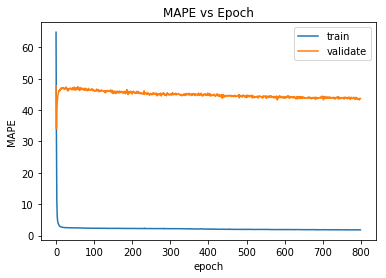

In [19]:
# summarize history for loss
plt.plot(history1.history['mean_absolute_percentage_error'])
plt.plot(history1.history['val_mean_absolute_percentage_error'])
#plt.ylim(0, 10)
plt.title('MAPE vs Epoch')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [20]:
print("\n%s: %.2f%%" % (model1.metrics_names[2], scores1[2]))


mean_absolute_percentage_error: 43.67%


In [21]:
print("\n%s: %.2f(MW)" % (model1.metrics_names[1], scores1[1])) 


mean_absolute_error: 551.51(MW)


### 3.1.2 Ridge

In [22]:
def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def mae_cv_train(model):
    mae= -cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv = 5)
    return(mae)

def mae_cv_test(model):
    mae= -cross_val_score(model, X_test, y_test, scoring="neg_mean_absolute_error", cv = 5)
    return(mae)

def mape_no_cv(model, X, y):
    y_pred = model.predict(X)
    mape = np.abs((y-y_pred))/np.abs(y) # Check this definition
    return np.mean(mape)
    
def mae_no_cv(model, X, y):
    y_pred = model.predict(X)
    return mean_absolute_error(y, y_pred) # Check the order of the inputs here

In [23]:
# Find the validation score
mape_ridge = mape_no_cv(ridge, X_test, y_test)
mae_ridge = mae_no_cv(ridge, X_test, y_test)
print("Ridge MAPE on Test set :", mape_ridge)
print("Rige MAE on Test set :", mae_ridge)

Ridge MAPE on Test set : 0.015608664969769518
Rige MAE on Test set : 19.864581901686797


## 3.2 Bootstrapping the MAPE and MAE
We directly resample the observations from the test data. 

In [24]:
# Function to plot the distribution
import seaborn as sns

def hist(series):
    fig, ax = plt.subplots()
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.9, 'edgecolor':'black', 'color': sns.color_palette('Blues')[-1]},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    return fig, ax

In [25]:
%%time


# Settings
S = 10000 # Number of bootstrap replications (start small!)
n = len(y_test) # It is useful to store the size of the data

# Generating the bootstrap samples
# The bootstrap sample has the same size as the original sample

mape_boot = []
mae_boot = []

for i in range(S):
    
    # Get the boostrap random indexes
    bootstrap_index = np.random.randint(n, size=n)
    
    # draws a sample of size n from X_test and y_test with replacement
    X_test_bootstrap_sample = X_test[bootstrap_index]
    y_test_bootstrap_sample = y_test[bootstrap_index]
    
    # Now, we have our bootstrap sample. Lets fit the model and find the error metrics
    y_pred = ridge.predict(X_test_bootstrap_sample)
    
    # Find the MAPE and MAE
    mape = np.mean(np.abs((y_test_bootstrap_sample-y_pred))/np.abs(y_test_bootstrap_sample))
    mae = mean_absolute_error(y_test_bootstrap_sample, y_pred)
    
    # Bootstrap  statistic
    mape_boot.append(mape)
    mae_boot.append(mae)

CPU times: user 12.9 s, sys: 62.4 ms, total: 13 s
Wall time: 3.24 s


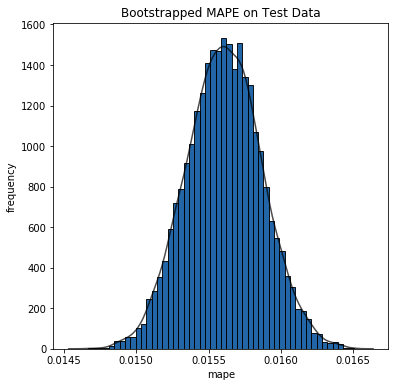

In [26]:
fig, ax = plt.subplots(figsize=(6,6))
sns.distplot(mape_boot, ax=ax, hist_kws={'alpha': 0.9, 'edgecolor':'black', 'color': sns.color_palette('Blues')[-1]},  
                 kde_kws={'color': 'black', 'alpha': 0.7})

plt.title('Bootstrapped MAPE on Test Data')
plt.ylabel('frequency')
plt.xlabel('mape')
plt.show()
#fig.savefig('model15_bootstrapped_rmse_instantaneous_combined.png', bbox_inches='tight')

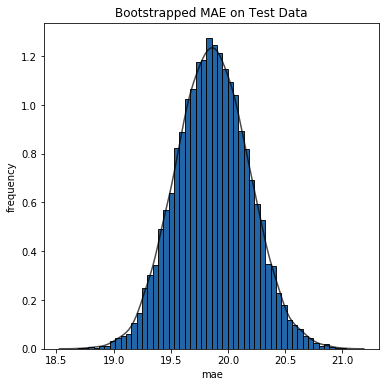

In [27]:
fig, ax = plt.subplots(figsize=(6,6))
sns.distplot(mae_boot, ax=ax, hist_kws={'alpha': 0.9, 'edgecolor':'black', 'color': sns.color_palette('Blues')[-1]},  
                 kde_kws={'color': 'black', 'alpha': 0.7})

plt.title('Bootstrapped MAE on Test Data')
plt.ylabel('frequency')
plt.xlabel('mae')
plt.show()
#fig.savefig('model15_bootstrapped_rmse_instantaneous_combined.png', bbox_inches='tight')

### 3.2.1 95% CI
#### 3.2.1.1 Pivotal CI
We can now use a bootstrap pivotal confidence interval to find the 95% CI

In [28]:
print('The lower interval for MAPE is: ', 2*mape_ridge-np.percentile(mape_boot, 0.975))
print('The upper interval for MAPE is: ', 2*mape_ridge-np.percentile(mape_boot, 0.025))

The lower interval for MAPE is:  0.01620819361638261
The upper interval for MAPE is:  0.016455729210856387


In [29]:
print('The lower interval for MAE is: ', 2*mae_ridge-np.percentile(mae_boot, 0.975))
print('The upper interval for MAE is: ', 2*mae_ridge-np.percentile(mae_boot, 0.025))

The lower interval for MAE is:  20.5925069948142
The upper interval for MAE is:  20.93208141056983


#### 3.2.1.2 Percentile Interval

In [30]:
print('The lower interval for MAPE is: ', np.percentile(mape_boot, 0.025))
print('The upper interval for MAPE is: ', np.percentile(mape_boot, 0.975))

The lower interval for MAPE is:  0.014761600728682649
The upper interval for MAPE is:  0.015009136323156425


In [31]:
print('The lower interval for MAE is: ', np.percentile(mae_boot, 0.025))
print('The upper interval for MAE is: ', np.percentile(mae_boot, 0.975))

The lower interval for MAE is:  18.797082392803766
The upper interval for MAE is:  19.136656808559394


## 3.3 Bootstrapping Improvement over Industry Model

In [ ]:
# Read in the data
df_industry = pd.read_csv('../../../0. Data/demand_lagged_industry_181017.csv')
#df['period'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M')
df_industry.sort_values(by='time', ascending=True, inplace=True)

# Remove NaN values
df_industry.dropna(axis=0, inplace=True)
df_industry.reset_index(drop=True,inplace=True)

# Create training and test sets
split_point_industry = 14251
df_train_validate_industry = df_industry.iloc[0:split_point_industry,:]
df_test_industry = df_industry.iloc[split_point_industry:,:]


# Create training and validation sets
split_point_industry = 11419
df_train_industry = df_train_validate_industry.iloc[0:split_point_industry,:]
df_validate_industry = df_train_validate_industry.iloc[split_point_industry:,:]


# Shuffle 
from sklearn.utils import shuffle
df_train_industry = shuffle(df_train_industry)
df_validate_industry = shuffle(df_validate_industry)
df_test_industry = shuffle(df_test_industry)


# Convert the data
X_train_industry = df_train_industry[["log_1_2", "log_2_3", "log_3_4", "log_4_5", "log_336_337", "log_337_338", "log_338_339", "log_339_340"]].values
y_train_industry = df_train_industry[['demand']].values


# Convert the data
X_validate_industry = df_validate_industry[["log_1_2", "log_2_3", "log_3_4", "log_4_5", "log_336_337", "log_337_338", "log_338_339", "log_339_340"]].values
y_validate_industry = df_validate_industry[['demand']].values


# Convert the data
X_test_industry = df_test_industry[["log_1_2", "log_2_3", "log_3_4", "log_4_5", "log_336_337", "log_337_338", "log_338_339", "log_339_340"]].values
y_test_industry = df_test_industry[['demand']].values

# Standardise the input
sc_industry = StandardScaler().fit(X_train_industry)
X_train_industry = sc_industry.transform(X_train_industry)
X_validate_industry = sc_industry.transform(X_validate_industry)
X_test_industry = sc_industry.transform(X_test_industry)


# Find the size of the input
n_input = X_train_industry.shape[1]

model3 = Sequential()
model3.add(Dense(16, input_dim=n_input, activation='relu'))
model3.add(Dense(8, activation='relu'))
model3.add(Dense(1, activation='linear')) # Regression problem so we want linear output


# ## 2.3 Compile the Model
model3.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_error','mean_squared_error'])

# Create a tuple of the test data
validation_data_industry = (X_test_industry, y_test_industry)

# Fit the model
history3 = model3.fit(X_train_industry, y_train_industry, epochs=500, batch_size=32, validation_data=validation_data_industry)

In [ ]:
# Calculate the scores
scores3 = model3.evaluate(X_test_industry, y_test_industry)
print("\n%s: %.2f%%" % (model3.metrics_names[0], scores3[0]))
print("\n%s: %.2f(MW)" % (model3.metrics_names[1], scores3[1])) 

In [ ]:
%%time


# Settings
S = 5000 # Number of bootstrap replications (start small!)
n = len(y_test) # It is useful to store the size of the data
n_industry = len(y_test_industry)

# Generating the bootstrap samples
# The bootstrap sample has the same size as the original sample

mape_boot_diff = []
mae_boot_diff = []

for i in range(S):
    
    # Get the boostrap random indexes
    bootstrap_index = np.random.randint(n, size=n)
    bootstrap_index_industry = np.random.randint(n_industry, size=n_industry)
    
    # draws a sample of size n from X_test and y_test with replacement
    X_test_bootstrap_sample = X_test[bootstrap_index]
    y_test_bootstrap_sample = y_test[bootstrap_index]
    X_test_bootstrap_sample_industry = X_test_industry[bootstrap_index_industry]
    y_test_bootstrap_sample_industry = y_test_industry[bootstrap_index_industry]
    
    # Now, we have our bootstrap sample. Lets fit the model and find the error metrics
    y_pred_ridge = ridge.predict(X_test_bootstrap_sample)
    y_pred_industry = model3.predict(X_test_bootstrap_sample_industry)
    
    # Find the MAPE and MAE
    mape_ridge = np.mean(np.abs((y_test_bootstrap_sample-y_pred_ridge))/np.abs(y_test_bootstrap_sample))
    mae_ridge = mean_absolute_error(y_test_bootstrap_sample, y_pred_ridge)
    
    mape_industry = np.mean(np.abs((y_test_bootstrap_sample_industry-y_pred_industry))/np.abs(y_test_bootstrap_sample_industry))
    mae_industry = mean_absolute_error(y_test_bootstrap_sample_industry, y_pred_industry)
    
    # Bootstrap  statistic
    mape_boot_diff.append(mape_industry-mape_ridge)
    mae_boot_diff.append(mae_industry-mae_ridge)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
sns.distplot(mape_boot_diff, ax=ax, hist_kws={'alpha': 0.9, 'edgecolor':'black', 'color': sns.color_palette('Blues')[-1]},  
                 kde_kws={'color': 'black', 'alpha': 0.7})

plt.title('Bootstrapped MAPE Difference on Test Data')
plt.ylabel('frequency')
plt.xlabel('mape difference')
plt.show()
#fig.savefig('model15_bootstrapped_rmse_instantaneous_combined.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
sns.distplot(mae_boot_diff, ax=ax, hist_kws={'alpha': 0.9, 'edgecolor':'black', 'color': sns.color_palette('Blues')[-1]},  
                 kde_kws={'color': 'black', 'alpha': 0.7})

plt.title('Bootstrapped MAE Difference on Test Data')
plt.ylabel('frequency')
plt.xlabel('mae difference')
plt.show()
#fig.savefig('model15_bootstrapped_rmse_instantaneous_combined.png', bbox_inches='tight')

### 3.3.1 95% CI

In [ ]:
mape_diff = scores3[0]/100 - mape_ridge
mae_diff = scores3[1] - mae_ridge

#### 3.3.1.1 Pivotal

In [ ]:
print('The lower interval for MAPE Difference is: ', 2*mape_diff-np.percentile(mape_boot_diff, 0.975))
print('The upper interval for MAPE Difference is: ', 2*mape_diff-np.percentile(mape_boot_diff, 0.025))

In [ ]:
print('The lower interval for MAE Difference is: ', 2*mae_diff-np.percentile(mae_boot_diff, 0.975))
print('The upper interval for MAE Difference is: ', 2*mae_diff-np.percentile(mae_boot_diff, 0.025))

#### 3.3.1.2 Pivotal

In [ ]:
print('The lower interval for MAPE Difference is: ', np.percentile(mape_boot_diff, 0.025))
print('The upper interval for MAPE Difference is: ', np.percentile(mape_boot_diff, 0.975))

In [ ]:
print('The lower interval for MAE Difference is: ', np.percentile(mae_boot_diff, 0.025))
print('The upper interval for MAE Difference is: ', np.percentile(mae_boot_diff, 0.975))